# Classifier using LSTM layers

## 1. Importing Libraries

In [1]:
import torch

import numpy as np
import pandas as pd

data_folder = '../data/ctrpts'

EPOCHS = 10
BATCH_SIZE = 40

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 2. Data Preprocessing

### 2.1. Loading the data

In [2]:
import os


def get_categories_from_data(folder, n=None):
    """
    This function retrieves category names from file names in a specified folder. 
    The category name is assumed to be a substring of the file name, starting from the 17th character and ending 7 characters before the end of the file name.
    If the substring is empty, it is not added to the list of categories.
    If a limit 'n' is specified, only the first 'n' categories are returned.

    Parameters:
    folder (str): The path to the folder containing the files.
    n (int, optional): The maximum number of categories to return. If not specified, all categories are returned.

    Returns:
    list: A list of category names.
    """
    files = os.listdir(folder)
    categories = [file[16:-7] for file in files if len(file[16:-7]) > 0]
    return categories if n is None else categories[:n]

#classes = get_categories_from_data(data_folder)
classes = ["camera", "cell phone"]
class_id = dict(zip(classes, range(len(classes))))

camera_data = np.load(f'../data/ctrlpts/camera_ctrlpt.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/ctrlpts/cell_phone_ctrlpt.npz', allow_pickle=True, encoding='latin1')

class_id

{'camera': 0, 'cell phone': 1}

In [3]:
from sklearn.model_selection import train_test_split

# Limiting data to 5000 points per class
def slice_data(data):
    # Assuming that the data arrays in each 'train', 'test', 'valid' are already shuffled
    sliced = []
    for key in ['train', 'test', 'valid']:
        # Slicing each segment
        sliced.append(data[key])
    # Concatenate slices from train, test, valid
    return np.concatenate(sliced)

# Slicing the data
camera_sliced = slice_data(camera_data)[:5000]
cellphone_sliced = slice_data(cellphone_data)[:5000]

# Concatenate all sliced data
def concatenate_data(*datasets):
    features = []
    labels = []
    for data, cid in zip(datasets, class_id.values()):
        features.append(data)
        labels.extend([cid] * len(data))
    features = np.concatenate(features)
    labels = np.array(labels)
    return features, labels

features, labels = concatenate_data(camera_sliced, cellphone_sliced)

# Split into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000,), (8000,), (2000,), (2000,))

In [5]:
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from scipy.interpolate import interp1d

def standardize_lengths(data, target_length=29):
    standardized_data = []

    for sequence in data:
        # Current length of the sequence
        current_length = sequence.shape[0]
        
        # Create an array of indices based on current length
        current_indices = np.linspace(0, 1, current_length)
        
        # Target indices for interpolation
        target_indices = np.linspace(0, 1, target_length)
        
        # Initialize interpolated sequence
        interpolated_sequence = np.zeros((target_length, sequence.shape[1]))
        
        # Interpolate each channel
        for i in range(sequence.shape[1]):
            # Interpolate the i-th channel
            interpolator = interp1d(current_indices, sequence[:, i], kind='linear')
            interpolated_sequence[:, i] = interpolator(target_indices)
        
        # Append the interpolated sequence to the standardized data list
        standardized_data.append(interpolated_sequence)

    return np.array(standardized_data)

# Apply standardization on X_train and X_test
X_train_standardized = standardize_lengths(X_train)
X_test_standardized = standardize_lengths(X_test)

def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.

    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long).to(device))

    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train_standardized, X_test_standardized, y_train, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
print(len(train_loader))
print(len(test_loader))

200
50


In [7]:
X_train_standardized.shape, X_test_standardized.shape

((8000, 29, 3), (2000, 29, 3))

## 3. Model Building

### 3.1. Quantum Layer

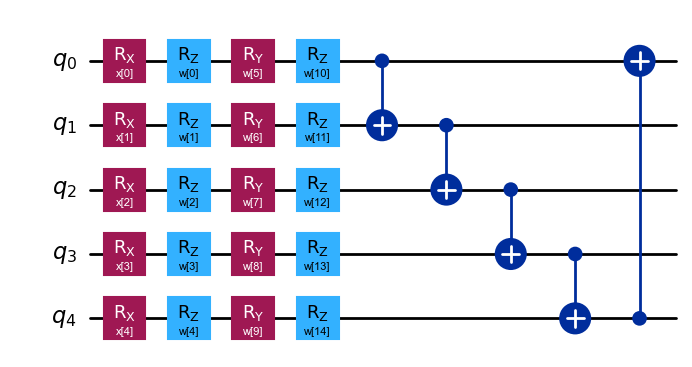

In [8]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)
    
    for i in range(n):
        circuit.rx(features[i], i)
    
    return circuit
    
def quantum_ansatz(n: int) -> QuantumCircuit:
    # Creamos un circuito cuántico con n qubits.
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)
    
    # Asumiendo que 'weights' es una lista de valores de peso,
    # y la longitud es suficiente para aplicar Rz a cada qubit.
    for i in range(n):
        circuit.rz(weights[i], i)
        
    # Aplicar más rotaciones, que en la imagen parecen ser Ry
    for i in range(n):
        circuit.ry(weights[n+i], i)
        
    for i in range(n):
        circuit.rz(weights[2*n+i], i)
        
    # Aplicar entrelazamiento con puertas CNOT
    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)
    
    return circuit

# Define and create QNN
def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)
    
    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN (
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories

        # Convolutional layers
        #self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        #self.bn1 = nn.BatchNorm1d(num_features=16)
        #self.pool1 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        #self.bn2 = nn.BatchNorm1d(num_features=32)
        #self.pool2 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        #self.bn3 = nn.BatchNorm1d(num_features=64)
        #self.pool3 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        #self.bn4 = nn.BatchNorm1d(num_features=128)
        #self.pool4 = nn.AvgPool1d(kernel_size=2)

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=29, hidden_size=29, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=29, hidden_size=29, batch_first=True)
        
        self.pool5 = nn.AvgPool1d(kernel_size=2)

        # Dense layers
        self.fc1 = nn.Linear(14, 14)
        self.fc2 = nn.Linear(14, 14)

        # Quantum layer
        # self.fc3 = nn.Linear(14, n_qubits)
        # self.qnn = TorchConnector(create_qnn(n_qubits)[0])

        # Dense layer for classification
        self.fc4 = nn.Linear(14, num_categories)

        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        #x = x.permute(0, 2, 1)

        # Convolutional layers
        #x = F.relu(self.bn1(self.conv1(x)))
        #x = self.pool1(x)
        
        #x = F.relu(self.bn2(self.conv2(x)))
        #x = self.pool2(x)
        
        #x = F.relu(self.bn3(self.conv3(x)))
        #x = self.pool3(x)
        
        #x = F.relu(self.bn4(self.conv4(x)))
        #x = self.pool4(x)

        # Reshape for LSTM
        #x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool5(x)

        # Flatten the output for dense layer
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Quantum layer
        # x = F.relu(self.fc3(x))
        # x = self.qnn(x)

        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [10]:
checkpoint_filepath = 'models/2edition_lstm/best_model_weights_ctrlpts.pth'

In [11]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            
            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(100):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 200/200 [00:00<00:00, 206.51it/s]


Epoch 1, Accuracy: 0.74025, Loss: 0.4778503584861755, Validation Accuracy: 0.8955, Validation Loss: 0.2742972671985626


100%|██████████| 200/200 [00:01<00:00, 197.70it/s]


Epoch 2, Accuracy: 0.917125, Loss: 0.215846289973706, Validation Accuracy: 0.9215, Validation Loss: 0.20471349358558655


100%|██████████| 200/200 [00:00<00:00, 211.73it/s]


Epoch 3, Accuracy: 0.93575, Loss: 0.1715327504929155, Validation Accuracy: 0.922, Validation Loss: 0.2115464210510254


100%|██████████| 200/200 [00:00<00:00, 213.77it/s]


Epoch 4, Accuracy: 0.942625, Loss: 0.14951449024491012, Validation Accuracy: 0.929, Validation Loss: 0.18603016436100006


100%|██████████| 200/200 [00:01<00:00, 195.96it/s]


Epoch 5, Accuracy: 0.95175, Loss: 0.12714510182850064, Validation Accuracy: 0.9445, Validation Loss: 0.16131705045700073


100%|██████████| 200/200 [00:00<00:00, 212.90it/s]


Epoch 6, Accuracy: 0.955125, Loss: 0.12019713054411113, Validation Accuracy: 0.9405, Validation Loss: 0.16318462789058685


100%|██████████| 200/200 [00:00<00:00, 210.14it/s]


Epoch 7, Accuracy: 0.957375, Loss: 0.11504852547310293, Validation Accuracy: 0.9445, Validation Loss: 0.14579951763153076


100%|██████████| 200/200 [00:01<00:00, 196.23it/s]


Epoch 8, Accuracy: 0.962625, Loss: 0.1016802832018584, Validation Accuracy: 0.945, Validation Loss: 0.14628322422504425


100%|██████████| 200/200 [00:01<00:00, 191.40it/s]


Epoch 9, Accuracy: 0.961875, Loss: 0.09706958962138743, Validation Accuracy: 0.954, Validation Loss: 0.13042989373207092


100%|██████████| 200/200 [00:00<00:00, 200.72it/s]


Epoch 10, Accuracy: 0.968, Loss: 0.089690693304874, Validation Accuracy: 0.9535, Validation Loss: 0.13447177410125732


100%|██████████| 200/200 [00:00<00:00, 204.77it/s]


Epoch 11, Accuracy: 0.96975, Loss: 0.08136433800798841, Validation Accuracy: 0.9555, Validation Loss: 0.13859492540359497


100%|██████████| 200/200 [00:00<00:00, 213.51it/s]


Epoch 12, Accuracy: 0.9735, Loss: 0.07497580372844823, Validation Accuracy: 0.944, Validation Loss: 0.15287302434444427


100%|██████████| 200/200 [00:01<00:00, 194.94it/s]


Epoch 13, Accuracy: 0.97325, Loss: 0.07158058423083276, Validation Accuracy: 0.9545, Validation Loss: 0.12085112929344177


100%|██████████| 200/200 [00:01<00:00, 198.40it/s]


Epoch 14, Accuracy: 0.975375, Loss: 0.06618463338236324, Validation Accuracy: 0.9555, Validation Loss: 0.13999205827713013


100%|██████████| 200/200 [00:01<00:00, 199.91it/s]


Epoch 15, Accuracy: 0.978, Loss: 0.06121962279430591, Validation Accuracy: 0.9495, Validation Loss: 0.15583547949790955


100%|██████████| 200/200 [00:01<00:00, 196.51it/s]


Epoch 16, Accuracy: 0.981, Loss: 0.053357897904934365, Validation Accuracy: 0.953, Validation Loss: 0.14569194614887238


100%|██████████| 200/200 [00:00<00:00, 216.21it/s]


Epoch 17, Accuracy: 0.980875, Loss: 0.0538688329589786, Validation Accuracy: 0.956, Validation Loss: 0.13672779500484467


100%|██████████| 200/200 [00:00<00:00, 213.47it/s]


Epoch 18, Accuracy: 0.982125, Loss: 0.04840055566921365, Validation Accuracy: 0.956, Validation Loss: 0.16187013685703278


100%|██████████| 200/200 [00:01<00:00, 178.77it/s]


Epoch 19, Accuracy: 0.981875, Loss: 0.04970436262432486, Validation Accuracy: 0.955, Validation Loss: 0.13693702220916748


100%|██████████| 200/200 [00:01<00:00, 196.40it/s]


Epoch 20, Accuracy: 0.9865, Loss: 0.0392559221322881, Validation Accuracy: 0.958, Validation Loss: 0.14903473854064941


100%|██████████| 200/200 [00:00<00:00, 202.35it/s]


Epoch 21, Accuracy: 0.984875, Loss: 0.040721735972329046, Validation Accuracy: 0.955, Validation Loss: 0.15257102251052856


100%|██████████| 200/200 [00:01<00:00, 189.77it/s]


Epoch 22, Accuracy: 0.9885, Loss: 0.03327561779995449, Validation Accuracy: 0.96, Validation Loss: 0.17087498307228088


100%|██████████| 200/200 [00:01<00:00, 196.79it/s]


Epoch 23, Accuracy: 0.99075, Loss: 0.02842509080641321, Validation Accuracy: 0.946, Validation Loss: 0.21233941614627838


100%|██████████| 200/200 [00:01<00:00, 197.01it/s]


Epoch 24, Accuracy: 0.984375, Loss: 0.04288541784451809, Validation Accuracy: 0.962, Validation Loss: 0.14322242140769958


100%|██████████| 200/200 [00:01<00:00, 180.31it/s]


Epoch 25, Accuracy: 0.982625, Loss: 0.04614396548597142, Validation Accuracy: 0.9535, Validation Loss: 0.16875821352005005


100%|██████████| 200/200 [00:01<00:00, 192.62it/s]


Epoch 26, Accuracy: 0.99175, Loss: 0.02516989970637951, Validation Accuracy: 0.951, Validation Loss: 0.16158407926559448


100%|██████████| 200/200 [00:01<00:00, 191.54it/s]


Epoch 27, Accuracy: 0.994125, Loss: 0.018835963335586712, Validation Accuracy: 0.958, Validation Loss: 0.17483371496200562


100%|██████████| 200/200 [00:01<00:00, 197.43it/s]


Epoch 28, Accuracy: 0.99025, Loss: 0.026723111414466986, Validation Accuracy: 0.952, Validation Loss: 0.1655953824520111


100%|██████████| 200/200 [00:01<00:00, 198.97it/s]


Epoch 29, Accuracy: 0.989625, Loss: 0.02921929638570873, Validation Accuracy: 0.9575, Validation Loss: 0.148908793926239


100%|██████████| 200/200 [00:00<00:00, 215.24it/s]


Epoch 30, Accuracy: 0.995125, Loss: 0.015855149648996304, Validation Accuracy: 0.956, Validation Loss: 0.18963861465454102


100%|██████████| 200/200 [00:01<00:00, 199.07it/s]


Epoch 31, Accuracy: 0.993125, Loss: 0.019500333943178703, Validation Accuracy: 0.9565, Validation Loss: 0.19214487075805664


100%|██████████| 200/200 [00:00<00:00, 212.49it/s]


Epoch 32, Accuracy: 0.993, Loss: 0.018687359402319997, Validation Accuracy: 0.9605, Validation Loss: 0.1726313829421997


100%|██████████| 200/200 [00:00<00:00, 209.55it/s]


Epoch 33, Accuracy: 0.990375, Loss: 0.02417166084429482, Validation Accuracy: 0.959, Validation Loss: 0.1860104352235794


100%|██████████| 200/200 [00:00<00:00, 200.67it/s]


Epoch 34, Accuracy: 0.990625, Loss: 0.02589602502215712, Validation Accuracy: 0.9605, Validation Loss: 0.16057328879833221


100%|██████████| 200/200 [00:00<00:00, 213.84it/s]


Epoch 35, Accuracy: 0.993375, Loss: 0.020038763684715376, Validation Accuracy: 0.9625, Validation Loss: 0.16495805978775024


100%|██████████| 200/200 [00:01<00:00, 178.86it/s]


Epoch 36, Accuracy: 0.995625, Loss: 0.014309667416091543, Validation Accuracy: 0.9615, Validation Loss: 0.1959766000509262


100%|██████████| 200/200 [00:00<00:00, 213.35it/s]


Epoch 37, Accuracy: 0.996375, Loss: 0.011307812795275823, Validation Accuracy: 0.9635, Validation Loss: 0.1915585845708847


100%|██████████| 200/200 [00:00<00:00, 214.40it/s]


Epoch 38, Accuracy: 0.9945, Loss: 0.014452700548717985, Validation Accuracy: 0.9585, Validation Loss: 0.20172446966171265


100%|██████████| 200/200 [00:01<00:00, 192.07it/s]


Epoch 39, Accuracy: 0.995125, Loss: 0.014888345615509025, Validation Accuracy: 0.963, Validation Loss: 0.18017931282520294


100%|██████████| 200/200 [00:01<00:00, 192.35it/s]


Epoch 40, Accuracy: 0.99675, Loss: 0.009577363718417473, Validation Accuracy: 0.963, Validation Loss: 0.1926434189081192


100%|██████████| 200/200 [00:00<00:00, 210.85it/s]


Epoch 41, Accuracy: 0.996375, Loss: 0.011051142331925803, Validation Accuracy: 0.952, Validation Loss: 0.2406967729330063


100%|██████████| 200/200 [00:00<00:00, 207.90it/s]


Epoch 42, Accuracy: 0.992625, Loss: 0.020294892864149004, Validation Accuracy: 0.955, Validation Loss: 0.21813489496707916


100%|██████████| 200/200 [00:00<00:00, 221.47it/s]


Epoch 43, Accuracy: 0.995125, Loss: 0.015412788823650771, Validation Accuracy: 0.9555, Validation Loss: 0.21993595361709595


100%|██████████| 200/200 [00:01<00:00, 191.03it/s]


Epoch 44, Accuracy: 0.998625, Loss: 0.0045128511099756, Validation Accuracy: 0.9585, Validation Loss: 0.20330090820789337


100%|██████████| 200/200 [00:01<00:00, 195.15it/s]


Epoch 45, Accuracy: 0.992, Loss: 0.021520946125965567, Validation Accuracy: 0.9575, Validation Loss: 0.20020894706249237


100%|██████████| 200/200 [00:00<00:00, 206.31it/s]


Epoch 46, Accuracy: 0.99825, Loss: 0.006048353909573052, Validation Accuracy: 0.962, Validation Loss: 0.20133377611637115


100%|██████████| 200/200 [00:00<00:00, 207.17it/s]


Epoch 47, Accuracy: 0.99875, Loss: 0.004241305761347576, Validation Accuracy: 0.9625, Validation Loss: 0.21601097285747528


100%|██████████| 200/200 [00:01<00:00, 182.93it/s]


Epoch 48, Accuracy: 0.992625, Loss: 0.022451812296858407, Validation Accuracy: 0.957, Validation Loss: 0.2076588273048401


100%|██████████| 200/200 [00:01<00:00, 195.85it/s]


Epoch 49, Accuracy: 0.997125, Loss: 0.008583507259845646, Validation Accuracy: 0.96, Validation Loss: 0.19977493584156036


100%|██████████| 200/200 [00:00<00:00, 200.56it/s]


Epoch 50, Accuracy: 0.99975, Loss: 0.0020062597127616755, Validation Accuracy: 0.9625, Validation Loss: 0.20958948135375977


100%|██████████| 200/200 [00:00<00:00, 207.17it/s]


Epoch 51, Accuracy: 1.0, Loss: 0.0009079102288706054, Validation Accuracy: 0.9615, Validation Loss: 0.22747266292572021


100%|██████████| 200/200 [00:00<00:00, 226.31it/s]


Epoch 52, Accuracy: 1.0, Loss: 0.0005067663173258552, Validation Accuracy: 0.96, Validation Loss: 0.24346871674060822


100%|██████████| 200/200 [00:00<00:00, 224.16it/s]


Epoch 53, Accuracy: 1.0, Loss: 0.00035408359626217136, Validation Accuracy: 0.96, Validation Loss: 0.253534734249115


100%|██████████| 200/200 [00:01<00:00, 198.64it/s]


Epoch 54, Accuracy: 1.0, Loss: 0.0002695117412577019, Validation Accuracy: 0.961, Validation Loss: 0.2627921998500824


100%|██████████| 200/200 [00:00<00:00, 223.62it/s]


Epoch 55, Accuracy: 1.0, Loss: 0.00021783843794992208, Validation Accuracy: 0.9605, Validation Loss: 0.27045658230781555


100%|██████████| 200/200 [00:00<00:00, 208.99it/s]


Epoch 56, Accuracy: 1.0, Loss: 0.0001776265388093634, Validation Accuracy: 0.961, Validation Loss: 0.2780798673629761


100%|██████████| 200/200 [00:00<00:00, 215.66it/s]


Epoch 57, Accuracy: 1.0, Loss: 0.00014784425174639183, Validation Accuracy: 0.961, Validation Loss: 0.28463923931121826


100%|██████████| 200/200 [00:00<00:00, 222.70it/s]


Epoch 58, Accuracy: 1.0, Loss: 0.0001249838004537196, Validation Accuracy: 0.962, Validation Loss: 0.29431265592575073


100%|██████████| 200/200 [00:01<00:00, 199.12it/s]


Epoch 59, Accuracy: 1.0, Loss: 0.00010537392601690954, Validation Accuracy: 0.962, Validation Loss: 0.3009819984436035


100%|██████████| 200/200 [00:00<00:00, 204.75it/s]


Epoch 60, Accuracy: 1.0, Loss: 8.956937847642621e-05, Validation Accuracy: 0.962, Validation Loss: 0.3080853223800659


100%|██████████| 200/200 [00:01<00:00, 191.81it/s]


Epoch 61, Accuracy: 1.0, Loss: 7.69758954675126e-05, Validation Accuracy: 0.963, Validation Loss: 0.3143729269504547


100%|██████████| 200/200 [00:01<00:00, 177.75it/s]


Epoch 62, Accuracy: 1.0, Loss: 6.666787699600718e-05, Validation Accuracy: 0.963, Validation Loss: 0.3206363320350647


100%|██████████| 200/200 [00:01<00:00, 196.28it/s]


Epoch 63, Accuracy: 1.0, Loss: 5.741665063112578e-05, Validation Accuracy: 0.9635, Validation Loss: 0.32598790526390076


100%|██████████| 200/200 [00:01<00:00, 196.51it/s]


Epoch 64, Accuracy: 1.0, Loss: 4.9997990295480577e-05, Validation Accuracy: 0.9635, Validation Loss: 0.3321548402309418


100%|██████████| 200/200 [00:01<00:00, 175.74it/s]


Epoch 65, Accuracy: 1.0, Loss: 4.3410568531783154e-05, Validation Accuracy: 0.963, Validation Loss: 0.33942124247550964


100%|██████████| 200/200 [00:00<00:00, 201.80it/s]


Epoch 66, Accuracy: 1.0, Loss: 3.79393310780074e-05, Validation Accuracy: 0.9625, Validation Loss: 0.3451218903064728


100%|██████████| 200/200 [00:02<00:00, 94.33it/s] 


Epoch 67, Accuracy: 1.0, Loss: 3.318702201056567e-05, Validation Accuracy: 0.9635, Validation Loss: 0.349394828081131


100%|██████████| 200/200 [00:00<00:00, 214.78it/s]


Epoch 68, Accuracy: 1.0, Loss: 2.9134498634633132e-05, Validation Accuracy: 0.9635, Validation Loss: 0.3557608425617218


100%|██████████| 200/200 [00:00<00:00, 211.29it/s]


Epoch 69, Accuracy: 1.0, Loss: 2.540742085298753e-05, Validation Accuracy: 0.9635, Validation Loss: 0.3605034649372101


100%|██████████| 200/200 [00:01<00:00, 192.74it/s]


Epoch 70, Accuracy: 1.0, Loss: 2.247092553204766e-05, Validation Accuracy: 0.9635, Validation Loss: 0.3668915927410126


100%|██████████| 200/200 [00:01<00:00, 199.27it/s]


Epoch 71, Accuracy: 1.0, Loss: 1.971138196214639e-05, Validation Accuracy: 0.9635, Validation Loss: 0.37154853343963623


100%|██████████| 200/200 [00:00<00:00, 220.29it/s]


Epoch 72, Accuracy: 1.0, Loss: 1.7308750694340347e-05, Validation Accuracy: 0.963, Validation Loss: 0.37770187854766846


100%|██████████| 200/200 [00:00<00:00, 209.75it/s]


Epoch 73, Accuracy: 1.0, Loss: 1.528662553706539e-05, Validation Accuracy: 0.963, Validation Loss: 0.3830513656139374


100%|██████████| 200/200 [00:00<00:00, 210.04it/s]


Epoch 74, Accuracy: 1.0, Loss: 1.3540097483759616e-05, Validation Accuracy: 0.963, Validation Loss: 0.3882371485233307


100%|██████████| 200/200 [00:00<00:00, 215.90it/s]


Epoch 75, Accuracy: 1.0, Loss: 1.191767186774051e-05, Validation Accuracy: 0.963, Validation Loss: 0.3932531774044037


100%|██████████| 200/200 [00:00<00:00, 200.85it/s]


Epoch 76, Accuracy: 1.0, Loss: 1.054205759006166e-05, Validation Accuracy: 0.963, Validation Loss: 0.3982398211956024


100%|██████████| 200/200 [00:00<00:00, 224.19it/s]


Epoch 77, Accuracy: 1.0, Loss: 9.291883814341872e-06, Validation Accuracy: 0.963, Validation Loss: 0.40425652265548706


100%|██████████| 200/200 [00:00<00:00, 218.27it/s]


Epoch 78, Accuracy: 1.0, Loss: 8.2881059185258e-06, Validation Accuracy: 0.963, Validation Loss: 0.4087247848510742


100%|██████████| 200/200 [00:01<00:00, 195.84it/s]


Epoch 79, Accuracy: 1.0, Loss: 7.265987959002018e-06, Validation Accuracy: 0.963, Validation Loss: 0.4136281907558441


100%|██████████| 200/200 [00:00<00:00, 209.57it/s]


Epoch 80, Accuracy: 1.0, Loss: 6.465678162665967e-06, Validation Accuracy: 0.963, Validation Loss: 0.4202994406223297


100%|██████████| 200/200 [00:01<00:00, 175.68it/s]


Epoch 81, Accuracy: 1.0, Loss: 5.731641247219699e-06, Validation Accuracy: 0.963, Validation Loss: 0.4246189594268799


100%|██████████| 200/200 [00:01<00:00, 141.96it/s]


Epoch 82, Accuracy: 1.0, Loss: 5.0272612976209885e-06, Validation Accuracy: 0.963, Validation Loss: 0.4277869462966919


100%|██████████| 200/200 [00:01<00:00, 133.66it/s]


Epoch 83, Accuracy: 1.0, Loss: 4.507215518843033e-06, Validation Accuracy: 0.963, Validation Loss: 0.43436554074287415


100%|██████████| 200/200 [00:01<00:00, 147.58it/s]


Epoch 84, Accuracy: 1.0, Loss: 3.990712063344226e-06, Validation Accuracy: 0.963, Validation Loss: 0.4396411180496216


100%|██████████| 200/200 [00:00<00:00, 201.62it/s]


Epoch 85, Accuracy: 1.0, Loss: 3.543821118277002e-06, Validation Accuracy: 0.963, Validation Loss: 0.4454963803291321


100%|██████████| 200/200 [00:00<00:00, 214.64it/s]


Epoch 86, Accuracy: 1.0, Loss: 3.1312437114916493e-06, Validation Accuracy: 0.963, Validation Loss: 0.4486227035522461


100%|██████████| 200/200 [00:01<00:00, 194.40it/s]


Epoch 87, Accuracy: 1.0, Loss: 2.801209799074833e-06, Validation Accuracy: 0.963, Validation Loss: 0.45413196086883545


100%|██████████| 200/200 [00:01<00:00, 195.09it/s]


Epoch 88, Accuracy: 1.0, Loss: 2.47908285970988e-06, Validation Accuracy: 0.963, Validation Loss: 0.4597637951374054


100%|██████████| 200/200 [00:01<00:00, 195.30it/s]


Epoch 89, Accuracy: 1.0, Loss: 2.197962339129944e-06, Validation Accuracy: 0.963, Validation Loss: 0.46509847044944763


100%|██████████| 200/200 [00:01<00:00, 167.83it/s]


Epoch 90, Accuracy: 1.0, Loss: 1.9511148496698106e-06, Validation Accuracy: 0.963, Validation Loss: 0.4704345762729645


100%|██████████| 200/200 [00:01<00:00, 190.27it/s]


Epoch 91, Accuracy: 1.0, Loss: 1.7254199835026185e-06, Validation Accuracy: 0.963, Validation Loss: 0.4753696918487549


100%|██████████| 200/200 [00:01<00:00, 193.83it/s]


Epoch 92, Accuracy: 1.0, Loss: 1.5364197546130497e-06, Validation Accuracy: 0.963, Validation Loss: 0.48016372323036194


100%|██████████| 200/200 [00:01<00:00, 190.84it/s]


Epoch 93, Accuracy: 1.0, Loss: 1.3717776711552609e-06, Validation Accuracy: 0.9625, Validation Loss: 0.48537105321884155


100%|██████████| 200/200 [00:00<00:00, 224.24it/s]


Epoch 94, Accuracy: 1.0, Loss: 1.2096988554932686e-06, Validation Accuracy: 0.9625, Validation Loss: 0.49077335000038147


100%|██████████| 200/200 [00:00<00:00, 203.38it/s]


Epoch 95, Accuracy: 1.0, Loss: 1.0805145244274783e-06, Validation Accuracy: 0.9625, Validation Loss: 0.49484702944755554


100%|██████████| 200/200 [00:00<00:00, 200.63it/s]


Epoch 96, Accuracy: 1.0, Loss: 9.531499093573537e-07, Validation Accuracy: 0.963, Validation Loss: 0.5011743307113647


100%|██████████| 200/200 [00:00<00:00, 215.16it/s]


Epoch 97, Accuracy: 1.0, Loss: 8.495643483263926e-07, Validation Accuracy: 0.9625, Validation Loss: 0.5041916370391846


100%|██████████| 200/200 [00:00<00:00, 212.95it/s]


Epoch 98, Accuracy: 1.0, Loss: 7.596403567977639e-07, Validation Accuracy: 0.962, Validation Loss: 0.5103282332420349


100%|██████████| 200/200 [00:01<00:00, 179.68it/s]


Epoch 99, Accuracy: 1.0, Loss: 6.736650804617384e-07, Validation Accuracy: 0.9625, Validation Loss: 0.5157188773155212


100%|██████████| 200/200 [00:00<00:00, 212.26it/s]

Epoch 100, Accuracy: 1.0, Loss: 6.01009970968569e-07, Validation Accuracy: 0.9625, Validation Loss: 0.5194582939147949


## 5. Model Evaluation

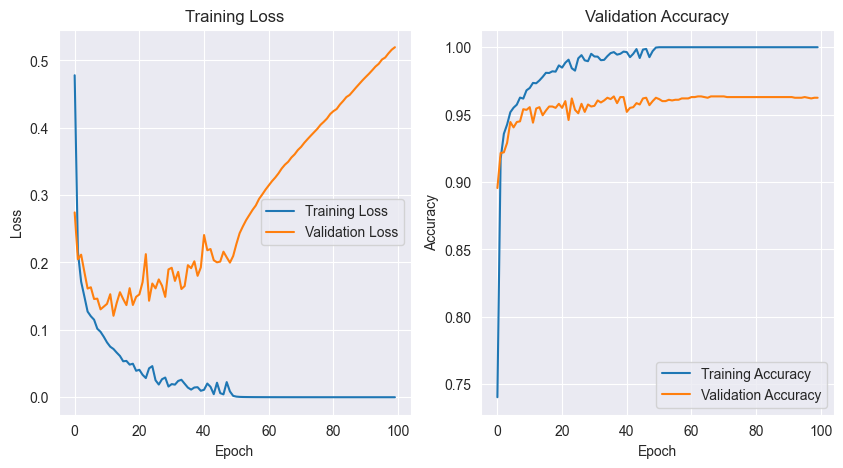

In [12]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [13]:
nn = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)
y_pred = nn.predict(X_test)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
pred = np.argmax(y_pred.data, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test.astype(np.int8), np.argmax(y_pred, axis=1))